# Animal classification AI

## TOC
- Student info
- Important note
- Important note
- Special credits
- Required imports and basic setup
- Step 1: Loading the data
   - 1.a: Saving the labels
   - 1.b: Saving dictionary of file paths
- Step 2: Data analysis
   - 2.a: showing some images
- Step 3: Choosing the predictor
   - 3.a: Loading in the pickle data
   - 3.b: Encoding the images
   - 3.c: Validate loaded data
- Step 4: Making validation set(s) and test set(s)
- Step 5: Training the model
- Step 6: Generating CSV for submission
- Step 7: finetuning the model
   - 7.a: Fine-tuning the input
      - 7.a.I: Automated functions
      - 7.a.II: Trying small feature amounts for all supplied descriptors
      - 7.a.III: Trying large feature amounts for all supplied descriptors
      - 7.a.IV: finding absolute minimum test score
   - 7.b: Fine-tuning the validation set
      - 7.b.I: Automated functions
      - 7.b.II: Finding optimal for SIFT
   - 7.c: Fine-tuning the model parameters
      - 7.c.I: Automated functions
      - 7.c.II: class_weight parameter
      - 7.c.III: fit_intercept parameter
      - 7.c.IV: max_iter parameter
      - 7.c.V: C parameter
   

## Student info
- **Name**: Bontinck Lennert
- **StudentID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping.

## Special credits
Some of the code used in this notebook is adopted or copied from the notebooks supplied in the Kaggle compition. A special thanks is given to Andries Rosseau for supplying us with this helpfull code.

## Required imports basic setup
All required imports for this file are taken care of once using the following code block. Installing the required libraries is discussed in the README of this GitHub repository. Some basic setup for the used libraries is also taken care of here

In [54]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook and make images high(er) resolution
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# used for counting files
import fnmatch

In [2]:
# datasets  location
dataset_path = '../images/'
# output location:
output_path = './'

In [3]:
# other path settings
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## Step 1: Loading the data
Before we can start exploring our data and making models we have to setup everything that is needed to access the data.

The data is provided in the Kaggle compition and saved under a folder "test" and "train" inside the folder "images" which is saved in this files parent directory as set up in the previous basic setup step.

### 1.a: Saving the labels
The training data provided is saved inside a folder which name corresponds to the label of the data inside that folder. Thus getting the labels of the data is nothing more then getting all folder names inside the "train" folder.

In [4]:
train_images_folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in train_images_folder_paths]))
amount_of_labels = label_strings.shape[0]

print("Amount of classes (labels): ", amount_of_labels)
print("\nLabels: ", label_strings)

Amount of classes (labels):  12

Labels:  ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


### 1.b: Saving dictionary of file paths
Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [5]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

## Step 2: Data analysis
Before rigorously testing different models available it's important to take a look at the data that's supplied to us. This will not only validate the data is correctly loaded in the previous step but will also give us some hint as to what our data looks like, what it's distribution is...

This step can be done in a separate Jupyter Notebook "data_analysis" and thus the code is not repeated here, we do however print some of the images here to be sure the setup in the previous step succeeded

### 2.a: showing some images
In this step we'll display the first five images in the train set provided for the Kaggle compitition.

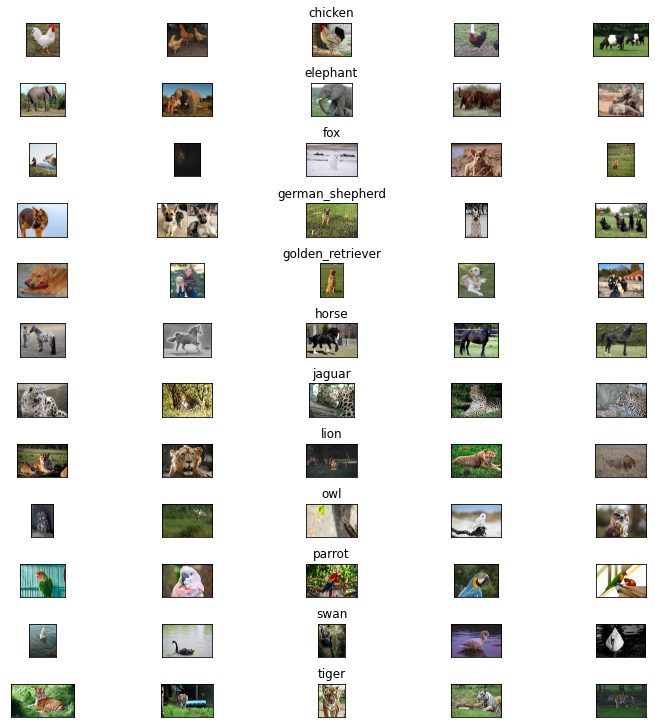

In [6]:
fig, axes = plt.subplots(nrows=amount_of_labels, ncols=5, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:5]]

    for colidx in range(5):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 2: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

## Step 3: Choosing the predictor
From the information gathered in step 2, a preffered predictor and proposed amount of features is loaded.

### 3.a: Loading in the pickle data
The "descriptor_desired" and "amount_of_features_per_image" parameters could benefit from fine-tuning. See inline comment to check wether or not they have been fine-tuned. More details in section: Fine-tuning the input.

The default "createCodebook" helper function is used to cluster the data/ get wanted amount of features. This can be optimised later.

In [6]:
# fine-tuning of these parameters has been done! See report for more details, section: Fine-tuning the input
descriptor_desired = 'sift'
amount_of_features_per_image = 100

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

# ----------------- get the wanted features ----------------- 
# Can be optimised later on!
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_features_per_image)

Number of encoded train images: 4042
Number of encoded test images: 4035
training took 15.442700147628784 seconds


### 3.b: Encoding the images
It's important to note that the test data has to be encoded with the clustered codebook as well!

In [7]:
# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)
    
# ----------------- make labels numerical ----------------- 
train_labels_text = train_labels[:]

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

print(train_labels_text[:10])
print(train_labels[:10])
    
# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)

['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]


### 3.c: Validate loaded data
This step prints some output to check wether or not the previous step succeeded.

In [8]:
# ----------------- print some info ----------------- 
print("Amoount of points available: ", len(train_features_from_pkl[0][2]))
print("Amoount of points requested: ", len(train_data[0]))

print("\nTrain labels: ", train_labels[:1])
print("Train data: \n", train_data[:1])

print("\nTest data by Kaggle: \n", test_data_by_kaggle[:1])

Amoount of points available:  500
Amoount of points requested:  100

Train labels:  [0]
Train data: 
 [array([0.13292778, 0.16615973, 0.09969584, 0.04984792, 0.04984792,
       0.06646389, 0.13292778, 0.        , 0.06646389, 0.14954376,
       0.04984792, 0.04984792, 0.21600765, 0.1827757 , 0.03323195,
       0.09969584, 0.19939168, 0.14954376, 0.01661597, 0.06646389,
       0.04984792, 0.01661597, 0.06646389, 0.09969584, 0.16615973,
       0.06646389, 0.04984792, 0.09969584, 0.        , 0.06646389,
       0.16615973, 0.08307986, 0.04984792, 0.11631181, 0.08307986,
       0.        , 0.04984792, 0.23262362, 0.13292778, 0.11631181,
       0.04984792, 0.09969584, 0.06646389, 0.08307986, 0.01661597,
       0.01661597, 0.        , 0.04984792, 0.14954376, 0.        ,
       0.04984792, 0.06646389, 0.19939168, 0.04984792, 0.06646389,
       0.09969584, 0.08307986, 0.04984792, 0.09969584, 0.06646389,
       0.08307986, 0.04984792, 0.11631181, 0.04984792, 0.04984792,
       0.11631181, 0.13292

## Step 4: Making validation set(s) and test set(s)
As per requirement of the Kaggle compitition, the score on the test data can not be used for optimilisation.
This is logical since the score would then not represent a score on completely unseen data anymore.
This is why we need to split the training data a second time into a training set and a validation set.

This splitting could benefit from fine-tuning.
See inline comment to check wether or not it has been fine-tuned.
It is chosen to take into account the unbalance of the dataset given.
More information in section: Fine-tuning the validation set

In [87]:
# random split: train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)
# taking into account unbalance: train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, random_state=0)

# fine-tuning of this parameter has been done! See report for more details, section: Fine-tuning the validation set
test_fraction = 0.15

train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)

#validating the split
print("Train labels: ", train_labels_split[:2])
print("\nTrain data: \n", train_data_split[:2])

Train labels:  [5 7]

Train data: 
 [array([0.12806604, 0.12806604, 0.1067217 , 0.04268868, 0.08537736,
       0.02134434, 0.02134434, 0.14941038, 0.06403302, 0.08537736,
       0.12806604, 0.04268868, 0.06403302, 0.08537736, 0.06403302,
       0.12806604, 0.19209906, 0.06403302, 0.1067217 , 0.14941038,
       0.1067217 , 0.1067217 , 0.        , 0.14941038, 0.06403302,
       0.12806604, 0.06403302, 0.02134434, 0.08537736, 0.        ,
       0.04268868, 0.1067217 , 0.12806604, 0.04268868, 0.02134434,
       0.06403302, 0.02134434, 0.02134434, 0.06403302, 0.04268868,
       0.04268868, 0.1067217 , 0.06403302, 0.1067217 , 0.06403302,
       0.17075472, 0.04268868, 0.14941038, 0.14941038, 0.06403302,
       0.14941038, 0.08537736, 0.1067217 , 0.        , 0.08537736,
       0.06403302, 0.02134434, 0.06403302, 0.04268868, 0.06403302,
       0.14941038, 0.06403302, 0.04268868, 0.08537736, 0.2134434 ,
       0.06403302, 0.1067217 , 0.04268868, 0.06403302, 0.02134434,
       0.14941038, 0.0853

## Step 5: Training the model
After all of this work we can finally start with training our model.

In [90]:
# edit to the optimals
class_weight = None
C = 1
max_iter = 250
fit_intercept = True

# step 1: import the model
from sklearn.linear_model import LogisticRegression

# step 2: create a model instance 
# (this is a model object that can be trained, tuned and used)

model = LogisticRegression(class_weight=class_weight,
                           C=C, 
                           max_iter=max_iter, 
                           fit_intercept=fit_intercept)

# step 3: train the model on the training data

model.fit(train_data_split, train_labels_split)

# step 4: predict labels for test data 

predictions_train = model.predict(train_data_split)
predictions_probability_train = model.predict_proba(train_data_split)

predictions_test = model.predict(test_data_split)
predictions_probability_test = model.predict_proba(test_data_split)

# step 4: calculate the accuracy of the model on the train set and on the test set
# We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

train_score = log_loss(train_labels_split, predictions_probability_train)
test_score = log_loss(test_labels_split, predictions_probability_test)

print("Accuracy of model: ",train_score," (train), ",test_score," (test)")

Accuracy of model:  1.5076227528197235  (train),  1.6277127369637159  (test)


## Step 6: Generating CSV for submission

In [32]:
# Do predictions on the actual test data
predictions_probability_test_data_by_kaggle = model.predict_proba(test_data_by_kaggle)

# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('2/linear_baseline', 'csv'))
helpers.writePredictionsToCsv(predictions_probability_test_data_by_kaggle, pred_file_path, label_strings)

---

---

## Step 7: finetuning the model
This step would actually be done first since the previous steps already have the optimal found parameters set.
However, it is included last in the Notebook since it contains al previous steps in 1 codeblock, which would make it hard to read.

### 7.a: Fine-tuning the input
Documented in the report, section: Fine-tuning the input

#### 7.a.I: Automated functions
These functions will make it easy to test different feature amounts and get data required for plotting.
Scoring is done with log_loss which corresponds to the scoring used on the Kaggle compitition.

In [7]:
# edit to current model
from sklearn.linear_model import LogisticRegression


# making the function, ignoring  annoying errors
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)
def try_different_feature_amounts(feature_amounts_to_test, descriptor_desired, test_fraction, iterations):
    #global vars
    train_scores = [0 for x in feature_amounts_to_test]
    test_scores = [0 for x in feature_amounts_to_test]

    for _ in range(iterations):
        for i in range(len(feature_amounts_to_test)):
            # ----------------- setup loop ----------------- 
            amount_of_features_per_image = feature_amounts_to_test[i]

            #edit to current model
            model = LogisticRegression()

            # ----------------- open pickle files ----------------- 
            with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
                train_features_from_pkl = pickle.load(pkl_file_train)

            with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
                test_features_from_pkl = pickle.load(pkl_file_test)

            # ----------------- get the wanted features ----------------- 
            clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_features_per_image)

            # ----------------- encode all train images ----------------- 
            train_data = []
            train_labels = []

            for image_features in train_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                train_data.append(bow_feature_vector)
                train_labels.append(image_features.label)

            # ----------------- make labels numerical ----------------- 
            train_labels_text = train_labels[:]

            label_encoder = sklearn.preprocessing.LabelEncoder()
            label_encoder.fit(label_strings)
            train_labels = label_encoder.transform(train_labels)

            # ----------------- encode all test images ----------------- 
            test_data_by_kaggle = []
            for image_features in test_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                test_data_by_kaggle.append(bow_feature_vector)

            # ----------------- making subsets ----------------- 
            train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)

            # ----------------- making model ----------------- 
            # step 3: train the model on the training data

            model.fit(train_data_split, train_labels_split)

            # step 4: predict labels for test data 
            predictions_probability_train = model.predict_proba(train_data_split)
            predictions_probability_test = model.predict_proba(test_data_split)

            # step 4: calculate the accuracy of the model on the train set and on the test set
            # We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

            train_score = log_loss(train_labels_split, predictions_probability_train)
            test_score = log_loss(test_labels_split, predictions_probability_test)
            
            train_scores[i] += train_score
            test_scores[i] += test_score

            print("Loop ", i, " -> Accuracy of " + descriptor_desired + " driven model with ", amount_of_features_per_image, " features : ",train_score," (train), ",test_score," (test)")
        
    return [[x/iterations for x in train_scores], [x/iterations for x in test_scores]]

#-------------------------

def try_different_inputs(feature_amounts_to_test, descriptors_to_test, test_fraction, iterations, img_suffix):
    result = [[descriptor_to_test, 0, 0] for descriptor_to_test in descriptors_to_test]
    for i in  range(len(descriptors_to_test)):
        train_scores, test_scores = try_different_feature_amounts(feature_amounts_to_test, descriptors_to_test[i], test_fraction, amount_of_averaging_iterations)
        result[i][1] = train_scores
        result[i][2] = test_scores
        
        #display graph from results
        x_axis = feature_amounts_to_test
        y_axis_train = train_scores
        y_axis_test = test_scores
        plt.plot(x_axis, y_axis_test,'b-', label="Test score", marker='o')
        plt.plot(x_axis, y_axis_train,'r-', label="Train score", marker='o')

        plt.xlabel('feature amount')
        plt.ylabel('score')
        plt.title('Score relative to feature amount - '+ descriptors_to_test[i])

        plt.legend(loc="upper left")
        plt.savefig("../graphs/2/2-LBM-feature_amount_" + descriptors_to_test[i] + "_" + img_suffix + ".png")

        plt.show()
        
    return result

    
#-------------------------

def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
#save to file example
#save_var_to_file("testabc", erdos_renye_network)
    
#open from file example
#from_file = get_var_from_file("testabc")




#### 7.a.II: Trying small feature amounts for all supplied descriptors
Here we will try to find the optimal feature amount and descriptor.
It's important to average over multiple runs since we're working with randoms

All graphs are saved to the graphs folder. The result is saved in a Pickle file for reusability

training took 11.14249324798584 seconds
Loop  0  -> Accuracy of daisy driven model with  5  features :  2.190503859781468  (train),  2.2355845840296893  (test)
training took 1.9303936958312988 seconds
Loop  1  -> Accuracy of daisy driven model with  20  features :  1.9726470373582934  (train),  2.0488741491961777  (test)
training took 6.873478889465332 seconds
Loop  2  -> Accuracy of daisy driven model with  50  features :  1.7040564880721765  (train),  1.808693892479743  (test)
training took 7.989274024963379 seconds
Loop  3  -> Accuracy of daisy driven model with  100  features :  1.5714449639496952  (train),  1.7104817934416576  (test)
training took 11.180503129959106 seconds
Loop  4  -> Accuracy of daisy driven model with  150  features :  1.4853395529117754  (train),  1.621122432297908  (test)
training took 17.335633993148804 seconds
Loop  5  -> Accuracy of daisy driven model with  250  features :  1.4105358736580293  (train),  1.5702044048271329  (test)
training took 43.115499973

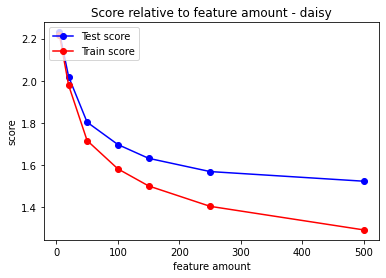

training took 11.712676763534546 seconds
Loop  0  -> Accuracy of orb driven model with  5  features :  2.306049721146189  (train),  2.306493072139846  (test)
training took 9.589989423751831 seconds
Loop  1  -> Accuracy of orb driven model with  20  features :  2.1573419687817683  (train),  2.1943695826602068  (test)
training took 10.34930682182312 seconds
Loop  2  -> Accuracy of orb driven model with  50  features :  2.0516887812506246  (train),  2.0973631496394534  (test)
training took 12.735626697540283 seconds
Loop  3  -> Accuracy of orb driven model with  100  features :  1.9387107547762161  (train),  2.0403640759647814  (test)
training took 14.49977993965149 seconds
Loop  4  -> Accuracy of orb driven model with  150  features :  1.8695120322302272  (train),  2.0266315387829716  (test)
training took 20.12776780128479 seconds
Loop  5  -> Accuracy of orb driven model with  250  features :  1.7703853377294774  (train),  2.0214026193012007  (test)
training took 32.732860803604126 secon

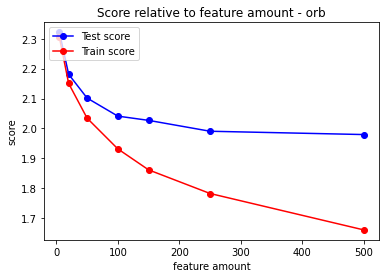

training took 3.6709835529327393 seconds
Loop  0  -> Accuracy of freak driven model with  5  features :  2.2373418132411538  (train),  2.263567706272308  (test)
training took 5.624972820281982 seconds
Loop  1  -> Accuracy of freak driven model with  20  features :  2.0498377245511663  (train),  2.080698426210471  (test)
training took 5.539353609085083 seconds
Loop  2  -> Accuracy of freak driven model with  50  features :  1.7909957157926932  (train),  1.8874664380203126  (test)
training took 7.845423698425293 seconds
Loop  3  -> Accuracy of freak driven model with  100  features :  1.6459432425228204  (train),  1.7804325032626802  (test)
training took 8.751477479934692 seconds
Loop  4  -> Accuracy of freak driven model with  150  features :  1.5592502707936173  (train),  1.7352170106657465  (test)
training took 13.974152565002441 seconds
Loop  5  -> Accuracy of freak driven model with  250  features :  1.4621140750270922  (train),  1.6681196035323473  (test)
training took 23.915407896

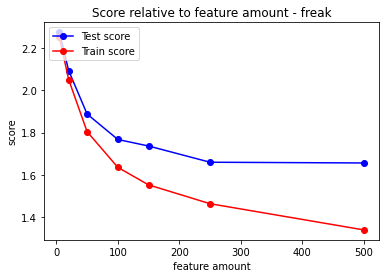

training took 4.3281285762786865 seconds
Loop  0  -> Accuracy of lucid driven model with  5  features :  2.2993023690303285  (train),  2.291731589461266  (test)
training took 1.203120470046997 seconds
Loop  1  -> Accuracy of lucid driven model with  20  features :  2.1549824991132724  (train),  2.207071548390062  (test)
training took 0.8571290969848633 seconds
Loop  2  -> Accuracy of lucid driven model with  50  features :  2.0800249220972344  (train),  2.1120034511438033  (test)
training took 5.297058343887329 seconds
Loop  3  -> Accuracy of lucid driven model with  100  features :  1.9583830555104846  (train),  2.0808247896011123  (test)
training took 6.513633966445923 seconds
Loop  4  -> Accuracy of lucid driven model with  150  features :  1.8863186896854343  (train),  2.050639583709335  (test)
training took 9.53315019607544 seconds
Loop  5  -> Accuracy of lucid driven model with  250  features :  1.7971216600502558  (train),  1.9890084346292387  (test)
training took 15.44951748847

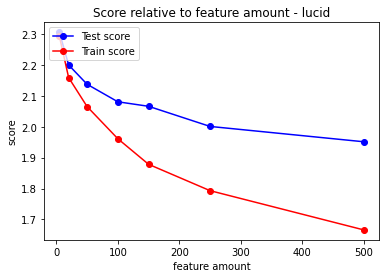

training took 4.633042573928833 seconds
Loop  0  -> Accuracy of vgg driven model with  5  features :  2.2784178319897768  (train),  2.2731017011984602  (test)
training took 4.93794846534729 seconds
Loop  1  -> Accuracy of vgg driven model with  20  features :  2.082740527693492  (train),  2.11412490740054  (test)
training took 5.178298473358154 seconds
Loop  2  -> Accuracy of vgg driven model with  50  features :  1.8655730009309608  (train),  1.9905735879584603  (test)
training took 6.050775527954102 seconds
Loop  3  -> Accuracy of vgg driven model with  100  features :  1.7078905662466564  (train),  1.8464547548632404  (test)
training took 10.610410690307617 seconds
Loop  4  -> Accuracy of vgg driven model with  150  features :  1.6046299043881331  (train),  1.773909619531888  (test)
training took 14.760109663009644 seconds
Loop  5  -> Accuracy of vgg driven model with  250  features :  1.4864478989860253  (train),  1.694149091837039  (test)
training took 31.644577980041504 seconds
L

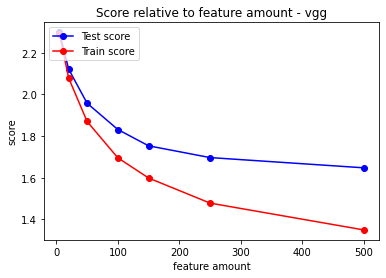

training took 4.010815382003784 seconds
Loop  0  -> Accuracy of boost_desc driven model with  5  features :  2.2765472514109715  (train),  2.2863679467426286  (test)
training took 5.703119993209839 seconds
Loop  1  -> Accuracy of boost_desc driven model with  20  features :  1.9834303557795323  (train),  2.0556054343872985  (test)
training took 5.85525107383728 seconds
Loop  2  -> Accuracy of boost_desc driven model with  50  features :  1.8244613475768452  (train),  1.8966543147483073  (test)
training took 6.479086875915527 seconds
Loop  3  -> Accuracy of boost_desc driven model with  100  features :  1.6655405071833342  (train),  1.8298758310732273  (test)
training took 8.541157007217407 seconds
Loop  4  -> Accuracy of boost_desc driven model with  150  features :  1.576270196505014  (train),  1.754663787424584  (test)
training took 13.064686298370361 seconds
Loop  5  -> Accuracy of boost_desc driven model with  250  features :  1.4928023129521093  (train),  1.7097895476346283  (test

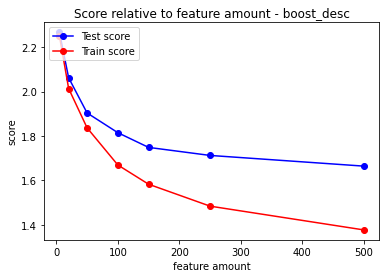

training took 11.384743928909302 seconds
Loop  0  -> Accuracy of sift driven model with  5  features :  1.9567823437776695  (train),  1.9695447006513211  (test)
training took 14.57403302192688 seconds
Loop  1  -> Accuracy of sift driven model with  20  features :  1.7039817405545892  (train),  1.7335856266681313  (test)
training took 11.967200994491577 seconds
Loop  2  -> Accuracy of sift driven model with  50  features :  1.6193923126620433  (train),  1.6626821361402353  (test)
training took 14.817090511322021 seconds
Loop  3  -> Accuracy of sift driven model with  100  features :  1.529762016116384  (train),  1.6176468513159032  (test)
training took 17.01916766166687 seconds
Loop  4  -> Accuracy of sift driven model with  150  features :  1.474694405507865  (train),  1.6271652903047988  (test)
training took 23.441593408584595 seconds
Loop  5  -> Accuracy of sift driven model with  250  features :  1.4268962191981982  (train),  1.5325835148522755  (test)
training took 50.6655914783477

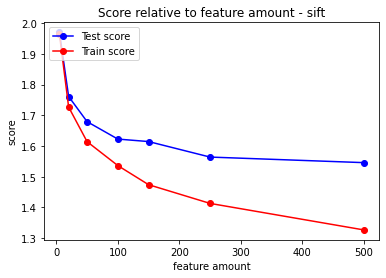

In [8]:
# Edit to your needs
feature_amounts_to_test = [5, 20, 50, 100, 150, 250, 500]
descriptors_to_test = ["daisy", "orb", "freak", "lucid", "vgg", "boost_desc", "sift"]
test_fraction = 0.25
amount_of_averaging_iterations = 5
img_suffix = "small_values"

result = try_different_inputs(feature_amounts_to_test, descriptors_to_test, test_fraction, amount_of_averaging_iterations, img_suffix)

#-------------------------

# Save result in file so that calculations can be done at a later stage
save_var_to_file("LBM_result_try_different_inputs_small", result)


Here we will make a summary graph of the train scores using the Pickle file.
Note; set the feature_amounts_to_test to the right value!

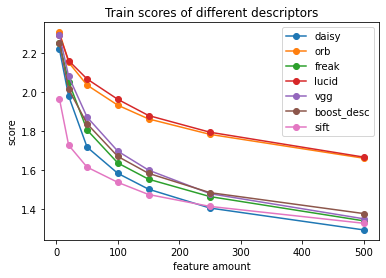

In [24]:
# edit this to your needs!
feature_amounts_to_test = [5, 20, 50, 100, 150, 250, 500]

# get result from pickle file
result_small_features = get_var_from_file("LBM_result_try_different_inputs_small")

# add all data to graph
for result in result_small_features:
    descriptor_name = result[0]
    train_scores = result[1]
       
    
    # add data to graph
    x_axis = feature_amounts_to_test
    y_axis_train = train_scores
    plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('feature amount')
plt.ylabel('score')    
plt.title('Train scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-train_scores_all_small.png")    
plt.show()

Here we will make a summary graph of the test scores using the Pickle file.
Note; set the feature_amounts_to_test to the right value!

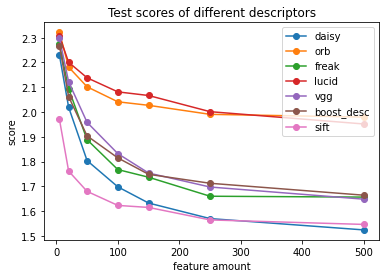

In [30]:
# edit this to your needs!
feature_amounts_to_test = [5, 20, 50, 100, 150, 250, 500]

# get result from pickle file
result_small_features = get_var_from_file("LBM_result_try_different_inputs_small")

# add all data to graph
for result in result_small_features:
    descriptor_name = result[0]
    test_scores = result[2]
       
    
    # add data to graph
    x_axis = feature_amounts_to_test
    y_axis_train = test_scores
    plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('feature amount')
plt.ylabel('score')    
plt.title('Test scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-test_scores_all_small.png")    
plt.show()

Here we will make a graph showing only the 2 best performing models

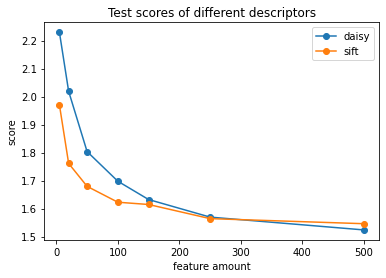

In [31]:
# edit this to your needs!
feature_amounts_to_test = [5, 20, 50, 100, 150, 250, 500]

# get result from pickle file
result_small_features = get_var_from_file("LBM_result_try_different_inputs_small")

# add all data to graph
for result in result_small_features:
    descriptor_name = result[0]
    test_scores = result[2]
       
    if (descriptor_name in ["daisy", "sift"]):
        # add data to graph
        x_axis = feature_amounts_to_test
        y_axis_train = test_scores
        plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('feature amount')
plt.ylabel('score')    
plt.title('Test scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-test_scores_best_small.png")    
plt.show()

#### 7.a.III: Trying large feature amounts for all supplied descriptors
Here we prove that overfitting can be done when having to many features.

training took 44.2095205783844 seconds
Loop  0  -> Accuracy of daisy driven model with  500  features :  1.2804631889356255  (train),  1.5321350752366214  (test)
training took 140.238374710083 seconds
Loop  1  -> Accuracy of daisy driven model with  1000  features :  1.2063658907846164  (train),  1.5125215249050183  (test)
training took 1258.1177082061768 seconds
Loop  2  -> Accuracy of daisy driven model with  3000  features :  1.1363015190395223  (train),  1.5327238549949471  (test)
training took 3270.263067483902 seconds
Loop  3  -> Accuracy of daisy driven model with  5000  features :  1.1332788520714956  (train),  1.5740634942170828  (test)


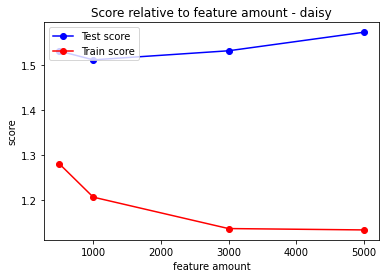

training took 35.5010290145874 seconds
Loop  0  -> Accuracy of orb driven model with  500  features :  1.6666148245339807  (train),  1.9843558693764853  (test)
training took 101.64059853553772 seconds
Loop  1  -> Accuracy of orb driven model with  1000  features :  1.556444444464995  (train),  1.9573315732727745  (test)
training took 658.740612745285 seconds
Loop  2  -> Accuracy of orb driven model with  3000  features :  1.4751537647975448  (train),  2.0500834165183095  (test)
training took 1668.094878435135 seconds
Loop  3  -> Accuracy of orb driven model with  5000  features :  1.4869521911408214  (train),  2.071073386723051  (test)


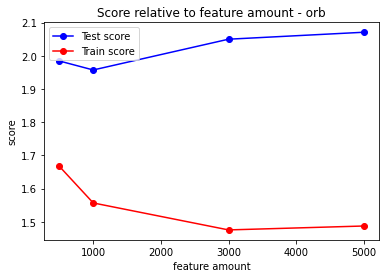

training took 21.61961054801941 seconds
Loop  0  -> Accuracy of freak driven model with  500  features :  1.3491831650345334  (train),  1.6341094359913066  (test)
training took 58.982722759246826 seconds
Loop  1  -> Accuracy of freak driven model with  1000  features :  1.274454876925778  (train),  1.6528388539472025  (test)
training took 598.1557853221893 seconds
Loop  2  -> Accuracy of freak driven model with  3000  features :  1.2298587822230747  (train),  1.7521170256394087  (test)
training took 950.5308787822723 seconds
Loop  3  -> Accuracy of freak driven model with  5000  features :  1.2601999403954485  (train),  1.7845911084662274  (test)


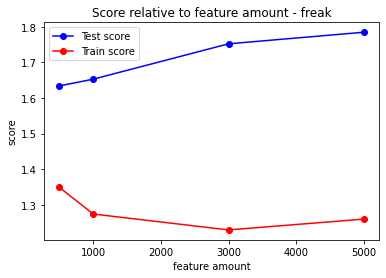

training took 15.792016506195068 seconds
Loop  0  -> Accuracy of lucid driven model with  500  features :  1.6654660037110882  (train),  1.9552916070423563  (test)
training took 42.10090160369873 seconds
Loop  1  -> Accuracy of lucid driven model with  1000  features :  1.5514673124769163  (train),  1.927918277108413  (test)
training took 474.4111511707306 seconds
Loop  2  -> Accuracy of lucid driven model with  3000  features :  1.4178544431210276  (train),  1.9217357049814112  (test)
training took 1029.5930094718933 seconds
Loop  3  -> Accuracy of lucid driven model with  5000  features :  1.4001795705379256  (train),  1.8958244831648248  (test)


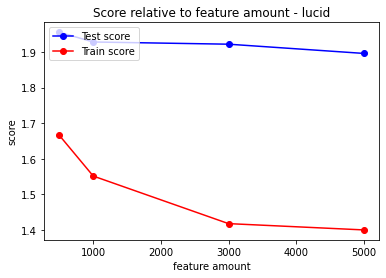

training took 29.074835777282715 seconds
Loop  0  -> Accuracy of vgg driven model with  500  features :  1.3403681795515794  (train),  1.6798376739419105  (test)
training took 87.36266016960144 seconds
Loop  1  -> Accuracy of vgg driven model with  1000  features :  1.2756749683672837  (train),  1.6389462857345092  (test)
training took 737.1707644462585 seconds
Loop  2  -> Accuracy of vgg driven model with  3000  features :  1.2167803680830738  (train),  1.7062071591356118  (test)
training took 2496.3387706279755 seconds
Loop  3  -> Accuracy of vgg driven model with  5000  features :  1.2328083249286157  (train),  1.7398709995245347  (test)


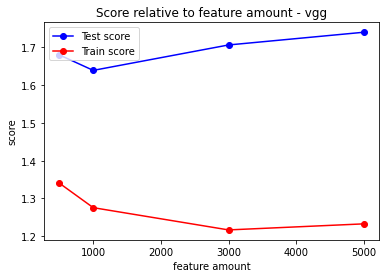

training took 19.712841272354126 seconds
Loop  0  -> Accuracy of boost_desc driven model with  500  features :  1.3649889145167928  (train),  1.68849797131438  (test)
training took 60.474419832229614 seconds
Loop  1  -> Accuracy of boost_desc driven model with  1000  features :  1.282330930670295  (train),  1.691350543381442  (test)
training took 511.32998180389404 seconds
Loop  2  -> Accuracy of boost_desc driven model with  3000  features :  1.2449649706494261  (train),  1.7402945320368008  (test)
training took 953.611245393753 seconds
Loop  3  -> Accuracy of boost_desc driven model with  5000  features :  1.2606284948725182  (train),  1.780165247593972  (test)


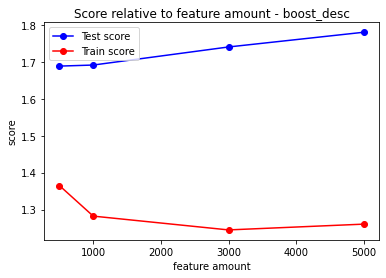

training took 55.3055579662323 seconds
Loop  0  -> Accuracy of sift driven model with  500  features :  1.3241988395661555  (train),  1.5562811836925503  (test)
training took 132.31519484519958 seconds
Loop  1  -> Accuracy of sift driven model with  1000  features :  1.2526299149234659  (train),  1.545437940640008  (test)
training took 1146.5486736297607 seconds
Loop  2  -> Accuracy of sift driven model with  3000  features :  1.1943152558382546  (train),  1.611276355161812  (test)
training took 3382.719795227051 seconds
Loop  3  -> Accuracy of sift driven model with  5000  features :  1.1984866212656222  (train),  1.6508314746611348  (test)


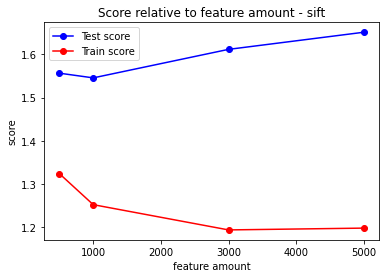

In [10]:
# Edit to your needs
feature_amounts_to_test = [500, 1000, 3000, 5000]
descriptors_to_test = ["daisy", "orb", "freak", "lucid", "vgg", "boost_desc", "sift"]
test_fraction = 0.25
amount_of_averaging_iterations = 1
img_suffix = "large_values"

result = try_different_inputs(feature_amounts_to_test, descriptors_to_test, test_fraction, amount_of_averaging_iterations, img_suffix)

#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("LBM_result_try_different_inputs_large", result)


Here we will make a summary graph of the train scores using the Pickle file.
Note; set the feature_amounts_to_test to the right value!

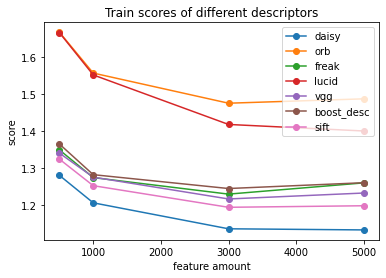

In [27]:
# edit this to your needs!
feature_amounts_to_test = [500, 1000, 3000, 5000]

# get result from pickle file
result_large_features = get_var_from_file("LBM_result_try_different_inputs_large")

# add all data to graph
for result in result_large_features:
    descriptor_name = result[0]
    train_scores = result[1]
       
    
    # add data to graph
    x_axis = feature_amounts_to_test
    y_axis_train = train_scores
    plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('feature amount')
plt.ylabel('score')    
plt.title('Train scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-train_scores_all_large.png")    
plt.show()

Here we will make a summary graph of the train scores using the Pickle file.
Note; set the feature_amounts_to_test to the right value!

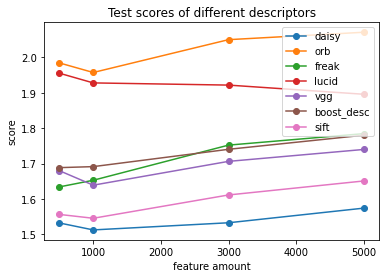

In [28]:
# edit this to your needs!
feature_amounts_to_test = [500, 1000, 3000, 5000]

# get result from pickle file
result_large_features = get_var_from_file("LBM_result_try_different_inputs_large")

# add all data to graph
for result in result_large_features:
    descriptor_name = result[0]
    test_scores = result[2]
       
    
    # add data to graph
    x_axis = feature_amounts_to_test
    y_axis_train = test_scores
    plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('feature amount')
plt.ylabel('score')    
plt.title('Test scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-test_scores_all_large.png")    
plt.show()

Here we will make a graph showing only the 2 best performing models

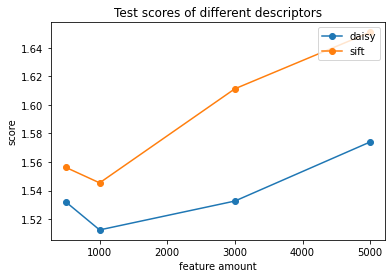

In [33]:
# edit this to your needs!
feature_amounts_to_test = [500, 1000, 3000, 5000]

# get result from pickle file
result_large_features = get_var_from_file("LBM_result_try_different_inputs_large")

# add all data to graph
for result in result_large_features:
    descriptor_name = result[0]
    test_scores = result[2]
       
    if (descriptor_name in ["daisy", "sift"]):
        # add data to graph
        x_axis = feature_amounts_to_test
        y_axis_train = test_scores
        plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('feature amount')
plt.ylabel('score')    
plt.title('Test scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-test_scores_best_large.png")    
plt.show()

#### 7.a.IV: finding absolute minimum test score

training took 52.89052081108093 seconds
Loop  0  -> Accuracy of daisy driven model with  500  features :  1.289819325558397  (train),  1.5267791091212306  (test)
training took 106.50093841552734 seconds
Loop  1  -> Accuracy of daisy driven model with  750  features :  1.2294133795482252  (train),  1.5313855199083328  (test)
training took 134.57931685447693 seconds
Loop  2  -> Accuracy of daisy driven model with  1000  features :  1.2324189972869135  (train),  1.5191469348227777  (test)
training took 253.4157750606537 seconds
Loop  3  -> Accuracy of daisy driven model with  1250  features :  1.1933215418529592  (train),  1.4989853998214686  (test)
training took 368.1155731678009 seconds
Loop  4  -> Accuracy of daisy driven model with  1500  features :  1.1703074837406264  (train),  1.5210930758905408  (test)
training took 53.28504157066345 seconds
Loop  0  -> Accuracy of daisy driven model with  500  features :  1.2927713466712383  (train),  1.5176811024758186  (test)
training took 101.

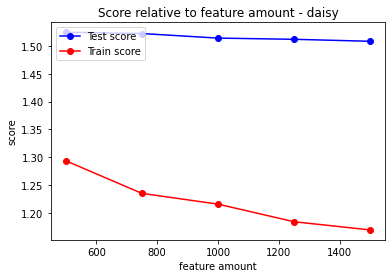

In [35]:
# Edit to your needs
feature_amounts_to_test = [500, 750, 1000, 1250, 1500]
descriptors_to_test = ["daisy"]
test_fraction = 0.25
amount_of_averaging_iterations = 3
img_suffix = "daisy_optimal"

result = try_different_inputs(feature_amounts_to_test, descriptors_to_test, test_fraction, amount_of_averaging_iterations, img_suffix)

#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("LBM_result_try_different_inputs_large_optimal", result)


Here we will make a graph of this data

### 7.b: Fine-tuning the validation set
Documented in the report, section: Fine-tuning the validation set

#### 7.b.I: Automated functions
These functions will make it easy to test different validation set sizes and get the data required for plotting.
Scoring is done with log_loss which corresponds to the scoring used on the Kaggle compitition.

In [20]:
# edit to current model
from sklearn.linear_model import LogisticRegression


# making the function, ignoring  annoying errors
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)
def try_different_test_fractions(amount_of_features_per_image, descriptor_desired, test_fractions_to_test, iterations):
    #global vars
    train_scores = [0 for x in test_fractions_to_test]
    test_scores = [0 for x in test_fractions_to_test]

    for _ in range(iterations):
        for i in range(len(test_fractions_to_test)):
            # ----------------- setup loop ----------------- 
            test_fraction = test_fractions_to_test[i]

            #edit to current model
            model = LogisticRegression()

            # ----------------- open pickle files ----------------- 
            with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
                train_features_from_pkl = pickle.load(pkl_file_train)

            with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
                test_features_from_pkl = pickle.load(pkl_file_test)

            # ----------------- get the wanted features ----------------- 
            clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_features_per_image)

            # ----------------- encode all train images ----------------- 
            train_data = []
            train_labels = []

            for image_features in train_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                train_data.append(bow_feature_vector)
                train_labels.append(image_features.label)

            # ----------------- make labels numerical ----------------- 
            train_labels_text = train_labels[:]

            label_encoder = sklearn.preprocessing.LabelEncoder()
            label_encoder.fit(label_strings)
            train_labels = label_encoder.transform(train_labels)

            # ----------------- encode all test images ----------------- 
            test_data_by_kaggle = []
            for image_features in test_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                test_data_by_kaggle.append(bow_feature_vector)

            # ----------------- making subsets ----------------- 
            train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)

            # ----------------- making model ----------------- 
            # step 3: train the model on the training data

            model.fit(train_data_split, train_labels_split)

            # step 4: predict labels for test data 
            predictions_probability_train = model.predict_proba(train_data_split)
            predictions_probability_test = model.predict_proba(test_data_split)

            # step 4: calculate the accuracy of the model on the train set and on the test set
            # We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

            train_score = log_loss(train_labels_split, predictions_probability_train)
            test_score = log_loss(test_labels_split, predictions_probability_test)
            
            train_scores[i] += train_score
            test_scores[i] += test_score

            print("Loop ", i, " -> Accuracy of " + descriptor_desired + " driven model with ", amount_of_features_per_image, " features and ", test_fraction, " test size: ",train_score," (train), ",test_score," (test)")
        
    return [[x/iterations for x in train_scores], [x/iterations for x in test_scores]]

    
#-------------------------

def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
#save to file example
#save_var_to_file("testabc", erdos_renye_network)
    
#open from file example
#from_file = get_var_from_file("testabc")




#### 7.b.II: Finding optimal for SIFT

In [24]:
# Edit to your needs
amount_of_features_per_image = 100
descriptor_desired = "sift"
test_fractions_to_test = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
iterations = 5

result = try_different_test_fractions(amount_of_features_per_image, descriptor_desired, test_fractions_to_test, iterations)

#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("LBM_result_try_different_test_fractions_sift", result)


training took 16.937117338180542 seconds
Loop  0  -> Accuracy of sift driven model with  100  features and  0.05  test size:  1.507819302398112  (train),  1.5818227668363525  (test)
training took 18.154253721237183 seconds
Loop  1  -> Accuracy of sift driven model with  100  features and  0.1  test size:  1.5274936030715467  (train),  1.5642089898126794  (test)
training took 17.737022399902344 seconds
Loop  2  -> Accuracy of sift driven model with  100  features and  0.15  test size:  1.5238577942214449  (train),  1.5937858179614595  (test)
training took 20.567604780197144 seconds
Loop  3  -> Accuracy of sift driven model with  100  features and  0.2  test size:  1.5181450454520853  (train),  1.615019054880534  (test)
training took 17.547662496566772 seconds
Loop  4  -> Accuracy of sift driven model with  100  features and  0.25  test size:  1.530451478295754  (train),  1.6358925963929678  (test)
training took 17.356186151504517 seconds
Loop  5  -> Accuracy of sift driven model with  1

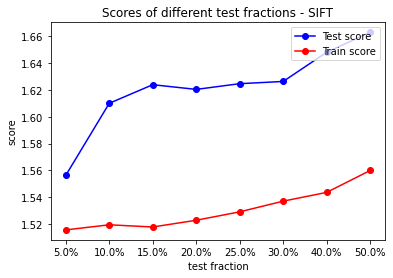

In [25]:
# edit this to your needs!
test_fractions_to_test = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]

# make values percentage
test_fractions_to_test = [str(x*100)+"%" for x in test_fractions_to_test]

# get result from pickle file
result_sample_size_sift = get_var_from_file("LBM_result_try_different_test_fractions_sift")
train_scores = result_sample_size_sift[0]
test_scores = result_sample_size_sift[1]

#display graph from results
x_axis = test_fractions_to_test
y_axis_train = train_scores
y_axis_test = test_scores
plt.plot(x_axis, y_axis_test,'b-', label="Test score", marker='o')
plt.plot(x_axis, y_axis_train,'r-', label="Train score", marker='o')

plt.xlabel('test fraction')
plt.ylabel('score')
plt.title('Scores of different test fractions - SIFT')

plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-test_size_sift.png")

plt.show()

### 7.c: Fine-tuning the model parameters
Now that all of the parameters available for the input are fine-tuned, the parameters of the model itself can be optimized.
Documented in the report, section: Fine-tuning the model parameters

#### 7.c.I: Automated functions

In [28]:
# edit to current model
from sklearn.linear_model import LogisticRegression


# making the function
def try_different_model_parameters(amount_of_features_per_image, descriptor_desired, test_fraction, iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters):
    # find the parameter that is being checked
    
    
    if isinstance(class_weight_parameters, list): 
        list_to_loop = class_weight_parameters
        c_parameters = [c_parameters]*len(list_to_loop)
        max_iter_parameters = [max_iter_parameters]*len(list_to_loop)
        fit_intercept_parameters = [fit_intercept_parameters]*len(list_to_loop)
    elif isinstance(c_parameters, list): 
        list_to_loop = c_parameters
        class_weight_parameters = [class_weight_parameters]*len(list_to_loop)
        max_iter_parameters = [max_iter_parameters]*len(list_to_loop)
        fit_intercept_parameters = [fit_intercept_parameters]*len(list_to_loop)
    elif isinstance(max_iter_parameters, list): 
        list_to_loop = max_iter_parameters
        class_weight_parameters = [class_weight_parameters]*len(list_to_loop)
        c_parameters = [c_parameters]*len(list_to_loop)
        fit_intercept_parameters = [fit_intercept_parameters]*len(list_to_loop)
    elif isinstance(fit_intercept_parameters, list): 
        list_to_loop = fit_intercept_parameters
        class_weight_parameters = [class_weight_parameters]*len(list_to_loop)
        c_parameters = [c_parameters]*len(list_to_loop)
        max_iter_parameters = [max_iter_parameters]*len(list_to_loop)
    else:
        raise Exception("Sorry, provide a list to be tried")
    
    
    #global vars
    train_scores = [0 for x in list_to_loop]
    test_scores = [0 for x in list_to_loop]

    for _ in range(iterations):
        for i in range(len(list_to_loop)):
            # ----------------- setup loop ----------------- 
            #edit to current model
            model = LogisticRegression(class_weight=class_weight_parameters[i], 
                                       C=c_parameters[i], 
                                       max_iter=max_iter_parameters[i], 
                                       fit_intercept=fit_intercept_parameters[i])

            # ----------------- open pickle files ----------------- 
            with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
                train_features_from_pkl = pickle.load(pkl_file_train)

            with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
                test_features_from_pkl = pickle.load(pkl_file_test)

            # ----------------- get the wanted features ----------------- 
            clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_features_per_image)

            # ----------------- encode all train images ----------------- 
            train_data = []
            train_labels = []

            for image_features in train_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                train_data.append(bow_feature_vector)
                train_labels.append(image_features.label)

            # ----------------- make labels numerical ----------------- 
            label_encoder = sklearn.preprocessing.LabelEncoder()
            label_encoder.fit(label_strings)
            train_labels = label_encoder.transform(train_labels)

            # ----------------- encode all test images ----------------- 
            test_data_by_kaggle = []
            for image_features in test_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                test_data_by_kaggle.append(bow_feature_vector)

            # ----------------- making subsets ----------------- 
            train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)

            # ----------------- making model ----------------- 
            # step 3: train the model on the training data

            model.fit(train_data_split, train_labels_split)

            # step 4: predict labels for test data 
            predictions_probability_train = model.predict_proba(train_data_split)
            predictions_probability_test = model.predict_proba(test_data_split)

            # step 4: calculate the accuracy of the model on the train set and on the test set
            # We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

            train_score = log_loss(train_labels_split, predictions_probability_train)
            test_score = log_loss(test_labels_split, predictions_probability_test)
            
            train_scores[i] += train_score
            test_scores[i] += test_score

            print("Loop ",
                  i,
                  " -> Accuracy of model with class_weight = ",
                  class_weight_parameters[i], 
                  ", C = ", 
                  c_parameters[i], 
                  " max_iter: ",
                  max_iter_parameters[i],
                  " fit_intercept: ",
                  fit_intercept_parameters[i],
                  ": ",
                  train_score,
                  " (train), "
                  ,test_score,
                  " (test)")
        
    return [[x/iterations for x in train_scores], [x/iterations for x in test_scores]]

    
#-------------------------

def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
#save to file example
#save_var_to_file("testabc", erdos_renye_network)
    
#open from file example
#from_file = get_var_from_file("testabc")




#### 7.c.II: class_weight parameter

In [33]:
amount_of_features_per_image = 100
descriptor_desired = "sift"
test_fraction = 0.15
iterations = 10
class_weight_parameters = [None, "balanced"]
c_parameters = 1
max_iter_parameters = 100
fit_intercept_parameters = True

result = try_different_model_parameters(amount_of_features_per_image, descriptor_desired, test_fraction, iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters)


#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("try_different_model_parameters_class_weight", result)

training took 14.429908514022827 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5365652643476615  (train),  1.5805582653434243  (test)
training took 17.92698574066162 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.5755003818087139  (train),  1.7189526674697688  (test)
training took 14.77332615852356 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5302375487709965  (train),  1.5698767966544722  (test)
training took 16.743685245513916 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.5826059738044298  (train),  1.6549552223709396  (test)
training took 16.872738122940063 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.507894175017145  (train),  1.6196648476909585  (test)
training took 15.920437335968018 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.5840411997354753  (train),  1.6715036922637936  (test)
training took 14.707278490066528 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5038306837857527  (train),  1.6202387444320188  (test)
training took 13.413737297058105 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.6040043843011633  (train),  1.6720355836386398  (test)
training took 14.111949920654297 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5349792572653922  (train),  1.5548136364011573  (test)
training took 16.735628843307495 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.5864069809894812  (train),  1.6619636500599604  (test)
training took 16.183812141418457 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5168839768979359  (train),  1.6243565047334838  (test)
training took 14.38207459449768 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.5928094778753448  (train),  1.6954427348388101  (test)
training took 14.095487356185913 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5255728019153314  (train),  1.554865472051343  (test)
training took 18.283329963684082 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.5927068471228871  (train),  1.7372208600390202  (test)
training took 17.571153163909912 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5291335988771877  (train),  1.5850897039152696  (test)
training took 17.960875749588013 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.594314601984211  (train),  1.6853351315368366  (test)
training took 15.954890251159668 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.501947396344  (train),  1.6806409169776633  (test)
training took 18.883480072021484 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.6030281869474565  (train),  1.6594885383701998  (test)
training took 15.006649017333984 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5147895902015565  (train),  1.6521196014118202  (test)
training took 16.3140926361084 seconds
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  1  max_iter:  100  fit_intercept:  True :  1.6011862856702104  (train),  1.6899282244421097  (test)


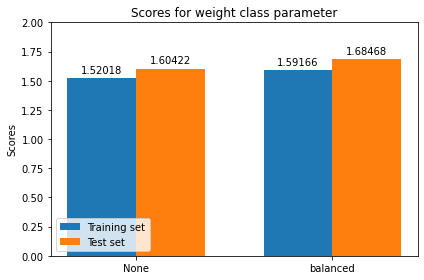

In [42]:
# edit this to your needs!
labels = ["None", "balanced"]

# get result from pickle file
result_sample_size_sift = get_var_from_file("try_different_model_parameters_class_weight")
train_scores = result_sample_size_sift[0]
train_scores = [round(x, 5) for x in train_scores]
test_scores = result_sample_size_sift[1]
test_scores = [round(x, 5) for x in test_scores]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_scores, width, label='Training set')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for weight class parameter')
ax.set_ylim([0,2])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower left")


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.savefig("../graphs/2/2-LBM-model_weight_class.png")
plt.show()

#### 7.c.III: fit_intercept parameter

In [45]:
amount_of_features_per_image = 100
descriptor_desired = "sift"
test_fraction = 0.15
iterations = 5
class_weight_parameters = None
c_parameters = 1
max_iter_parameters = 100
fit_intercept_parameters = [True, False]

result = try_different_model_parameters(amount_of_features_per_image, descriptor_desired, test_fraction, iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters)


#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("try_different_model_parameters_fit_intercept", result)

training took 16.417659282684326 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5225784739639243  (train),  1.6148195900384836  (test)
training took 17.492279291152954 seconds
Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  False :  1.5393214328522338  (train),  1.6056860331809397  (test)
training took 2.848098039627075 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5123390926056972  (train),  1.583230454825598  (test)
training took 17.385814905166626 seconds
Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  False :  1.5455572707161984  (train),  1.6486920060981893  (test)
training took 17.488967895507812 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5214373703092732  (train),  1.619832067023616  (test)
training took 17.097357273101807 seconds
Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  False :  1.5256415884362986  (train),  1.5987631385073544  (test)
training took 15.905041933059692 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5166353560727093  (train),  1.6222316313328562  (test)
training took 19.15585470199585 seconds
Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  False :  1.5203179027043878  (train),  1.65117339762534  (test)
training took 14.704293012619019 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5236670687817835  (train),  1.6116973422817167  (test)
training took 18.051971673965454 seconds
Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  False :  1.5476963736261526  (train),  1.6201565448263995  (test)


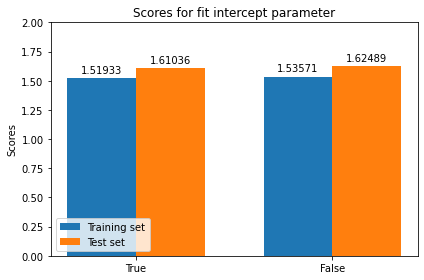

In [46]:
# edit this to your needs!
labels = ["True", "False"]

# get result from pickle file
result = get_var_from_file("try_different_model_parameters_fit_intercept")
train_scores = result[0]
train_scores = [round(x, 5) for x in train_scores]
test_scores = result[1]
test_scores = [round(x, 5) for x in test_scores]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_scores, width, label='Training set')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for fit intercept parameter')
ax.set_ylim([0,2])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower left")


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.savefig("../graphs/2/2-LBM-model_fit_intercept.png")
plt.show()

#### 7.c.IV: max_iter parameter

In [81]:
amount_of_features_per_image = 100
descriptor_desired = "sift"
test_fraction = 0.15
iterations = 5
class_weight_parameters = None
c_parameters = 1
max_iter_parameters = [50, 100, 150, 200, 250]
fit_intercept_parameters = True

result = try_different_model_parameters(amount_of_features_per_image, descriptor_desired, test_fraction, iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters)


#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("try_different_model_parameters_max_iter", result)

training took 15.322081327438354 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  50  fit_intercept:  True :  1.5252751170351346  (train),  1.6599276814670312  (test)
training took 14.955467939376831 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.505129267258871  (train),  1.6192347342545925  (test)
training took 17.429110288619995 seconds
Loop  2  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  150  fit_intercept:  True :  1.5224635336187904  (train),  1.5841647053954089  (test)
training took 17.376434803009033 seconds
Loop  3  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  200  fit_intercept:  True :  1.5202701138330832  (train),  1.6052924584537078  (test)
training took 17.198479175567627 seconds
Loop  4  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  250  fit_intercept:  True :  1.5317302671094926  (train),  1.5877241475837005  (test)
training took 14.22631311416626 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  50  fit_intercept:  True :  1.5211669813874884  (train),  1.6153834998479282  (test)
training took 18.33456587791443 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5166454978656685  (train),  1.60840884193778  (test)
training took 16.406620502471924 seconds
Loop  2  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  150  fit_intercept:  True :  1.5205780573874048  (train),  1.592279592603013  (test)
training took 17.373327016830444 seconds
Loop  3  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  200  fit_intercept:  True :  1.5116711328177443  (train),  1.6174805142662814  (test)
training took 15.39107608795166 seconds
Loop  4  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  250  fit_intercept:  True :  1.5206506607832422  (train),  1.5973845924848824  (test)
training took 19.172874450683594 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  50  fit_intercept:  True :  1.523720294717976  (train),  1.5816352700825456  (test)
training took 18.293559551239014 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5070325575054453  (train),  1.6562215653934909  (test)
training took 17.651541233062744 seconds
Loop  2  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  150  fit_intercept:  True :  1.5318196253351641  (train),  1.6006457291653118  (test)
training took 16.59349298477173 seconds
Loop  3  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  200  fit_intercept:  True :  1.5216187553928178  (train),  1.6277043994558766  (test)
training took 19.98160219192505 seconds
Loop  4  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  250  fit_intercept:  True :  1.5333910435001117  (train),  1.5972811482598077  (test)
training took 17.719136238098145 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  50  fit_intercept:  True :  1.5334081116440859  (train),  1.5730573973493456  (test)
training took 17.25639247894287 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5298453146494393  (train),  1.5595462683269548  (test)
training took 14.405426025390625 seconds
Loop  2  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  150  fit_intercept:  True :  1.5311213143880558  (train),  1.612422366409751  (test)
training took 15.072160720825195 seconds
Loop  3  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  200  fit_intercept:  True :  1.5347449441792376  (train),  1.5470444566514874  (test)
training took 15.89589524269104 seconds
Loop  4  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  250  fit_intercept:  True :  1.5309169430749783  (train),  1.555345345264482  (test)
training took 18.194953680038452 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  50  fit_intercept:  True :  1.5196815196816262  (train),  1.5736104465948453  (test)
training took 16.1858172416687 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  100  fit_intercept:  True :  1.5268554428218177  (train),  1.6256151826422691  (test)
training took 18.542393684387207 seconds
Loop  2  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  150  fit_intercept:  True :  1.5310229747255564  (train),  1.6135281366564533  (test)
training took 15.622982501983643 seconds
Loop  3  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  200  fit_intercept:  True :  1.5248798883896608  (train),  1.6291029926045122  (test)
training took 18.10530924797058 seconds
Loop  4  -> Accuracy of model with class_weight =  None , C =  1  max_iter:  250  fit_intercept:  True :  1.53199649135208  (train),  1.5531134165781013  (test)


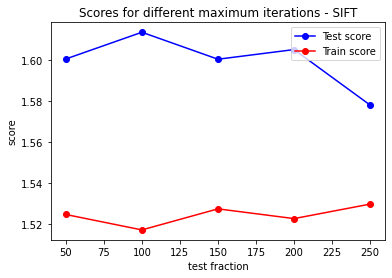

In [82]:
# edit this to your needs!
x_axis = [50, 100, 150, 200, 250]

# get result from pickle file
result = get_var_from_file("try_different_model_parameters_max_iter")
train_scores = result[0]
test_scores = result[1]

#display graph from results
y_axis_train = train_scores
y_axis_test = test_scores
plt.plot(x_axis, y_axis_test,'b-', label="Test score", marker='o')
plt.plot(x_axis, y_axis_train,'r-', label="Train score", marker='o')

plt.xlabel('test fraction')
plt.ylabel('score')
plt.title('Scores for different maximum iterations - SIFT')

plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-model_max_iter.png")

plt.show()

#### 7.c.V: C parameter

In [55]:
# Note that sweeping regularisation parameters is usually done on a logarithmic scale:

balanced_pipe_regul = Pipeline([,
    ('linearbaselinemodel',LogisticRegression(C=1.0, class_weight="balanced"))
])


# Set the parameters by cross-validation
tuned_parameters = [{'linearbaselinemodel__C': [1.0e-5,1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0, 
                                   10.0, 100.0, 1000.0,10000.0]}]

CV = GridSearchCV(balanced_pipe_regul, tuned_parameters, cv=5)
CV.fit(x_train, r_train)

print("Best parameter set found on development set: ", CV.best_params_)
# store the best optimization parameter for later reuse
bestC2 = CV.best_params_['linearbaselinemodel__C']

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    

SyntaxError: invalid syntax (<ipython-input-55-506e6b03988b>, line 3)